# Homework 7: scikit-image

Due Tuesday Apr 10, 6pm

## Counting objects

In class, we saw how to count the number of objects in a microscopy image.  Here, we will repeat that exercise, but make use of some of the algorithms in `scikit-image` to segment the image, and then to determine properties of the resulting objects.

As input, use the image `skimage.data.coins`.  Segment the image, and then calculate the area and eccentricity of each coin.

There are various ways to do this.  One would be:

1. Equalize the input image (see `skimage.exposure`)
2. Threshold the image (`skimage.filters.otsu`)
3. Remove objects touching the boundary (`skimage.segmentation.clear_border`)
4. Apply morphological closing (`skimage.morphology.closing`)
5. Remove small objects (`skimage.measure.regionprops`).
   Visualize the results if you want with `skimage.color.label2rgb`.
7. Calculate the area and eccentricity of each coin, and display the
   original image with this information on it (`matplotlib.pyplot.text` or `matplotlib.pyplot.annotate`)

In [1]:
%matplotlib inline
from skimage import data
from skimage import io
from skimage import exposure
from skimage import filters
from skimage import segmentation
from skimage import morphology
from skimage import measure
from skimage import color
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import numpy as np

/Users/kategroschner/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


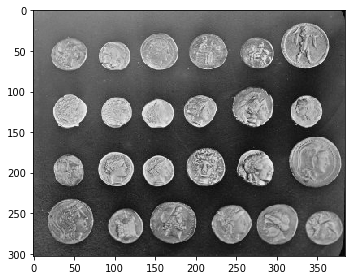

In [2]:
coins = data.coins()
io.imshow(coins)

### 1.1 Equalizing input image

In [3]:
eq_coins = exposure.equalize_adapthist(coins)

### 1.2 Thresholding using Otsu's Method

/Users/kategroschner/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


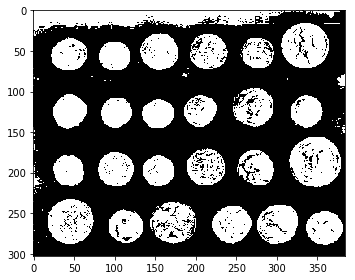

In [4]:
thresh = filters.threshold_otsu(eq_coins)
mask = eq_coins >= thresh
thresh_coins = eq_coins.copy()
thresh_coins[mask]=1
thresh_coins[~mask]=0
io.imshow(thresh_coins)

### 1.3 Segmenting

/Users/kategroschner/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


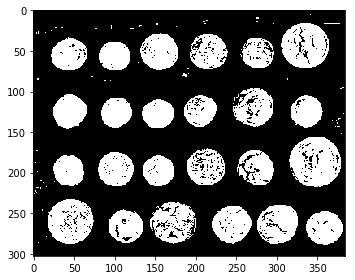

In [5]:
seg_coins = segmentation.clear_border(thresh_coins)
io.imshow(seg_coins)

### 1.4 Morphological closing

/Users/kategroschner/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


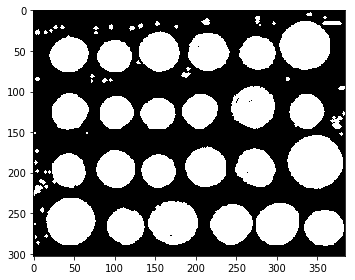

In [6]:
close_coins = morphology.dilation(morphology.dilation(morphology.closing(seg_coins)))
io.imshow(close_coins)

### 1.5 Removing small regions and collecting area and eccentricities

/Users/kategroschner/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


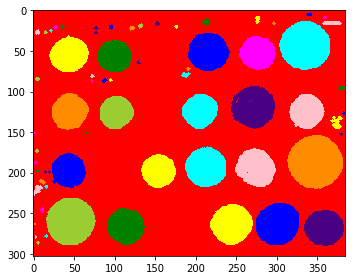

In [7]:
label_coins = measure.label(close_coins)
io.imshow(color.label2rgb(label_coins))
cleaned_coins = morphology.remove_small_objects(label_coins, min_size=1000)
coin_regions = measure.regionprops(cleaned_coins,eq_coins)
prop_bbox = []
areas = []
eccentricities = []
for region in coin_regions:
    prop_bbox.append(region.bbox)
    areas.append(region.area)
    eccentricities.append(region.eccentricity)
    

### 1.6 Annotating Image

In [8]:
eq_coins.shape

(303, 384)

Text(0.5,1,'Coins Labelled with Area in Pixels(top) followed by Eccentricities(bottom)')

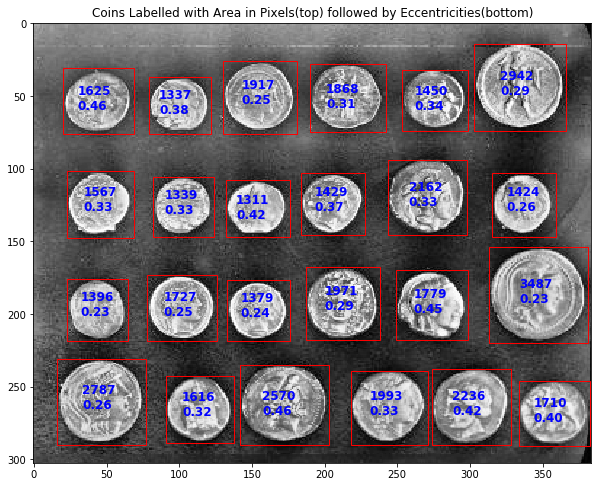

In [9]:
fig, ax = plt.subplots(1,figsize=(10,13))

ax.imshow(eq_coins, cmap='gray')
for idx, bbox in enumerate(prop_bbox):
    width = bbox[3]-bbox[1]
    height = bbox[2]-bbox[0]
    text = str(areas[idx])+'\n'+"{:0.2f}".format(eccentricities[idx])
    len_area = len(str(areas[idx]))
    ax.text(bbox[1]+(height//2)-12,bbox[0]+(width//2)+len_area,text,size = 'large',color='blue',weight = 'semibold')
    rect = patches.Rectangle((bbox[1],bbox[0]),width,height,fill=None,edgecolor = 'red')
    ax.add_patch(rect)
ax.set_title('Coins Labelled with Area in Pixels(top) followed by Eccentricities(bottom)')

## Panorama stitching

One of the scikit-image tutorials shows [how to do panorama stitching](https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/solutions/adv3_panorama-stitching-solution.ipynb).

Take 3 or 4 overlapping photos of your own, and use the procedure described to stitch your own panorama.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from skimage import transform
from skimage import io
from skimage.color import rgb2gray
from skimage.feature import ORB
from skimage.feature import match_descriptors
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac
from skimage.transform import SimilarityTransform
from skimage.transform import warp
from skimage.measure import label
from skimage.graph import route_through_array
from skimage.measure import label
from IPython.display import display

In [28]:
def compare(*images, **kwargs):
    """
    Utility function to display images side by side.
    
    Parameters
    ----------
    image0, image1, image2, ... : ndarrray
        Images to display.
    labels : list
        Labels for the different images.
    """
    f, axes = plt.subplots(len(images),1, **kwargs)
    axes = np.array(axes, ndmin=1)
    
    labels = kwargs.pop('labels', None)
    if labels is None:
        labels = [''] * len(images)
    
    for n, (image, label) in enumerate(zip(images, labels)):
        image = transform.rescale(image,0.8)
        axes[n].imshow(image)
        axes[n].set_title(label)
        axes[n].axis('off')
    
    f.tight_layout()

In [29]:
def make_pano_images(directory):
    """
    Function to import images from a directory contianing only those images and output them as 1/4 scale and grayscale
    """
    pano_imgs = io.ImageCollection('/Users/kategroschner/Downloads/bridge/*.JPG')
    img_dir = {}
    for idx, img in enumerate(pano_imgs):
        name ='pano'+str(idx)
        img_dir[name] = rgb2gray(transform.rescale(img,0.8))
    return(pano_imgs,img_dir['pano0'], img_dir['pano1'], img_dir['pano2'])

In [13]:
def feature_finder(pano0,pano1,pano2):
    """
    Function to find ORB keypoints and descriptors and then generate match points betweent the left and center image
    and the center and right image.
    """
    orb = ORB(n_keypoints=1000, fast_threshold=0.05)
    kypts = {}
    # Detect keypoints in pano0
    orb.detect_and_extract(pano0)
    kypts['keypoints0'] = orb.keypoints
    kypts['descriptors0'] = orb.descriptors

    # Detect keypoints in pano1 and pano2
    orb.detect_and_extract(pano1)
    kypts['keypoints1'] = orb.keypoints
    kypts['descriptors1'] = orb.descriptors

    orb.detect_and_extract(pano2)
    kypts['keypoints2'] = orb.keypoints
    kypts['descriptors2'] = orb.descriptors
    
    matches01 = match_descriptors(kypts['descriptors0'], kypts['descriptors1'], cross_check=True)
    matches12 = match_descriptors(kypts['descriptors1'], kypts['descriptors2'], cross_check=True)

    return(kypts, matches01, matches12)

In [14]:
def clean_features(pano0,pano1, pano2):
    """
    Function to run RANSAC to get rid of outliers and find the best matches among the detected ORB features
    """
    kypts, matches01, matches12 = feature_finder(pano0, pano1, pano2)
        # Select keypoints from
    #   * source (image to be registered): pano0
    #   * target (reference image): pano1, our middle frame registration target
    src = kypts['keypoints0'][matches01[:, 0]][:, ::-1]
    dst = kypts['keypoints1'][matches01[:, 1]][:, ::-1]

    model_robust01, inliers01 = ransac((src, dst), ProjectiveTransform,
                                       min_samples=4, residual_threshold=1, max_trials=300)

    # Select keypoints from
    #   * source (image to be registered): pano2
    #   * target (reference image): pano1, our middle frame registration target
    src = kypts['keypoints2'][matches12[:, 1]][:, ::-1]
    dst = kypts['keypoints1'][matches12[:, 0]][:, ::-1]

    model_robust12, inliers12 = ransac((src, dst), ProjectiveTransform,
                                       min_samples=4, residual_threshold=1, max_trials=300)
    
    return(model_robust01, inliers01,model_robust12, inliers12)

In [15]:
def warp_images(pano0,pano1,pano2, model_robust01, inliers01,model_robust12, inliers12):
    """
    Function to 
    """
    # Shape of middle image, our registration target
    r, c = pano1.shape[:2]

    # Note that transformations take coordinates in (x, y) format,
    # not (row, column), in order to be consistent with most literature
    corners = np.array([[0, 0],
                        [0, r],
                        [c, 0],
                        [c, r]])

    # Warp the image corners to their new positions
    warped_corners01 = model_robust01(corners)
    warped_corners12 = model_robust12(corners)

    # Find the extents of both the reference image and the warped
    # target image
    all_corners = np.vstack((warped_corners01, warped_corners12, corners))

    # The overall output shape will be max - min
    corner_min = np.min(all_corners, axis=0)
    corner_max = np.max(all_corners, axis=0)
    output_shape = (corner_max - corner_min)

    # Ensure integer shape with np.ceil and dtype conversion
    output_shape = np.ceil(output_shape[::-1]).astype(int)
    # This in-plane offset is the only necessary transformation for the middle image
    offset1 = SimilarityTransform(translation= -corner_min)

    # Translate pano1 into place
    pano1_warped = warp(pano1, offset1.inverse, order=3,
                        output_shape=output_shape, cval=-1)

    # Acquire the image mask for later use
    pano1_mask = (pano1_warped != -1)  # Mask == 1 inside image
    pano1_warped[~pano1_mask] = 0      # Return background values to 0
    # Warp pano0 to pano1
    transform01 = (model_robust01 + offset1).inverse
    pano0_warped = warp(pano0, transform01, order=3,
                        output_shape=output_shape, cval=-1)

    pano0_mask = (pano0_warped != -1)  # Mask == 1 inside image
    pano0_warped[~pano0_mask] = 0      # Return background values to 0
    # Warp pano2 to pano1
    transform12 = (model_robust12 + offset1).inverse
    pano2_warped = warp(pano2, transform12, order=3,
                        output_shape=output_shape, cval=-1)

    pano2_mask = (pano2_warped != -1)  # Mask == 1 inside image
    pano2_warped[~pano2_mask] = 0      # Return background values to 0
    return(output_shape,offset1, pano0_warped,pano1_warped,pano2_warped, pano0_mask, pano1_mask,pano2_mask)

In [16]:
def generate_costs(diff_image, mask, vertical=True, gradient_cutoff=2.):
    """
    Ensures equal-cost paths from edges to region of interest.
    
    Parameters
    ----------
    diff_image : (M, N) ndarray of floats
        Difference of two overlapping images.
    mask : (M, N) ndarray of bools
        Mask representing the region of interest in ``diff_image``.
    vertical : bool
        Control operation orientation.
    gradient_cutoff : float
        Controls how far out of parallel lines can be to edges before
        correction is terminated. The default (2.) is good for most cases.
        
    Returns
    -------
    costs_arr : (M, N) ndarray of floats
        Adjusted costs array, ready for use.
    """
    if vertical is not True:
        return tweak_costs(diff_image.T, mask.T, vertical=vertical,
                           gradient_cutoff=gradient_cutoff).T
    
    # Start with a high-cost array of 1's
    costs_arr = np.ones_like(diff_image)
    
    # Obtain extent of overlap
    row, col = mask.nonzero()
    cmin = col.min()
    cmax = col.max()

    # Label discrete regions
    cslice = slice(cmin, cmax + 1)
    labels = label(mask[:, cslice])
    
    # Find distance from edge to region
    upper = (labels == 0).sum(axis=0)
    lower = (labels == 2).sum(axis=0)
    
    # Reject areas of high change
    ugood = np.abs(np.gradient(upper)) < gradient_cutoff
    lgood = np.abs(np.gradient(lower)) < gradient_cutoff
    
    # Give areas slightly farther from edge a cost break
    costs_upper = np.ones_like(upper, dtype=np.float64)
    costs_lower = np.ones_like(lower, dtype=np.float64)
    costs_upper[ugood] = upper.min() / np.maximum(upper[ugood], 1)
    costs_lower[lgood] = lower.min() / np.maximum(lower[lgood], 1)
    
    # Expand from 1d back to 2d
    vdist = mask.shape[0]
    costs_upper = costs_upper[np.newaxis, :].repeat(vdist, axis=0)
    costs_lower = costs_lower[np.newaxis, :].repeat(vdist, axis=0)
    
    # Place these in output array
    costs_arr[:, cslice] = costs_upper * (labels == 0)
    costs_arr[:, cslice] +=  costs_lower * (labels == 2)
    
    # Finally, place the difference image
    costs_arr[mask] = diff_image[mask]
    
    return costs_arr

In [17]:
def mask_maker(output_shape,offset1, pano0_warped,pano1_warped,pano2_warped, pano0_mask, pano1_mask,pano2_mask):
    
    ymax = output_shape[1] - 1
    xmax = output_shape[0] - 1

    # Start anywhere along the top and bottom, left of center.
    mask_pts01 = [[0,    ymax // 3],
                  [xmax, ymax // 3]]

    # Start anywhere along the top and bottom, right of center.
    mask_pts12 = [[0,    2*ymax // 3],
                  [xmax, 2*ymax // 3]]
    costs01 = generate_costs(np.abs(pano0_warped - pano1_warped),
                         pano0_mask & pano1_mask)
    costs01[0, :] = 0
    costs01[-1, :] = 0
    pts, _ = route_through_array(costs01, mask_pts01[0], mask_pts01[1], fully_connected=True)

    # Convert list of lists to 2d coordinate array for easier indexing
    pts = np.array(pts)
    # Start with an array of zeros and place the path
    mask0 = np.zeros_like(pano0_warped, dtype=np.uint8)
    mask0[pts[:, 0], pts[:, 1]] = 1
    mask0 = (label(mask0, connectivity=1, background=-1) == 1)
    # Start with the absolute value of the difference image.
    # np.abs is necessary because we don't want negative costs!
    costs12 = generate_costs(np.abs(pano1_warped - pano2_warped),
                             pano1_mask & pano2_mask)

    # Allow the path to "slide" along top and bottom edges to the optimal 
    # horizontal position by setting top and bottom edges to zero cost
    costs12[0,  :] = 0
    costs12[-1, :] = 0
    costs12[mask0 > 0] = 1
    pts, _ = route_through_array(costs12, mask_pts12[0], mask_pts12[1], fully_connected=True)

    # Convert list of lists to 2d coordinate array for easier indexing
    pts = np.array(pts)
    mask2 = np.zeros_like(pano0_warped, dtype=np.uint8)
    mask2[pts[:, 0], pts[:, 1]] = 1
    mask2 = (label(mask2, connectivity=1, background=-1) == 3)
    mask1 = ~(mask0 | mask2).astype(bool)
    return(mask0,mask1,mask2)

In [18]:
def add_alpha(img, mask=None):
    """
    Adds a masked alpha channel to an image.
    
    Parameters
    ----------
    img : (M, N[, 3]) ndarray
        Image data, should be rank-2 or rank-3 with RGB channels
    mask : (M, N[, 3]) ndarray, optional
        Mask to be applied. If None, the alpha channel is added
        with full opacity assumed (1) at all locations.
    """
    from skimage.color import gray2rgb
    if mask is None:
        mask = np.ones_like(img)
        
    if img.ndim == 2:
        img = gray2rgb(img)
    
    return np.dstack((img, mask))

In [30]:
def combine_images(pano_imgs,model_robust01,model_robust12,output_shape,offset1, mask0, mask1, mask2):

    pano0_color = warp(transform.rescale(pano_imgs[0],0.8), \
                       (model_robust01 + offset1).inverse, order=3,
                       output_shape=output_shape, cval=0)

    pano1_color = warp(transform.rescale(pano_imgs[1],0.8), offset1.inverse, order=3,
                       output_shape=output_shape, cval=0)

    pano2_color = warp(transform.rescale(pano_imgs[2],0.8),\
                       (model_robust12 + offset1).inverse, order=3,
                       output_shape=output_shape, cval=0)
    pano0_final = add_alpha(pano0_color, mask0)
    pano1_final = add_alpha(pano1_color, mask1)
    pano2_final = add_alpha(pano2_color, mask2)
    fig, ax = plt.subplots(figsize=(12, 12))

    # Turn off matplotlib's interpolation
    ax.imshow(pano0_final, interpolation='none')
    ax.imshow(pano1_final, interpolation='none')
    ax.imshow(pano2_final, interpolation='none')

    fig.tight_layout()
    ax.axis('off');

In [31]:
def stitching_pipeline(directory):
    pano_imgs, pano0, pano1, pano2 = make_pano_images(directory)
    compare(*pano_imgs,figsize = (10,10))
    plt.gcf().suptitle('Original Images')
    features = clean_features(pano0,pano1, pano2)
    warps_masks = warp_images(pano0,pano1, pano2,*features)
    mask0,mask1,mask2 = mask_maker(*warps_masks)
    combine_images(pano_imgs,features[0],features[2],warps_masks[0],warps_masks[1], mask0, mask1, mask2)
    plt.gcf().suptitle('Stitched Together Panorama')

/Users/kategroschner/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/kategroschner/anaconda/lib/python3.6/site-packages/skimage/feature/match.py:49: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  if np.issubdtype(descriptors1.dtype, np.bool):


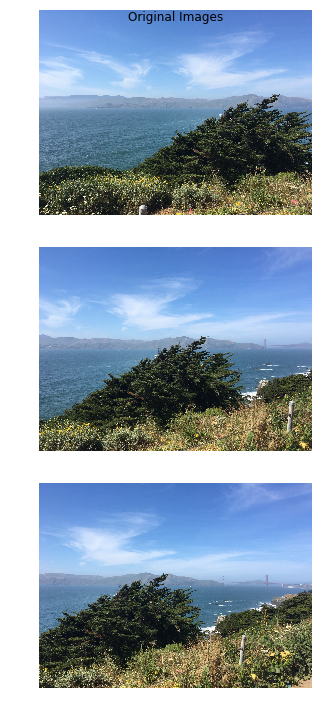

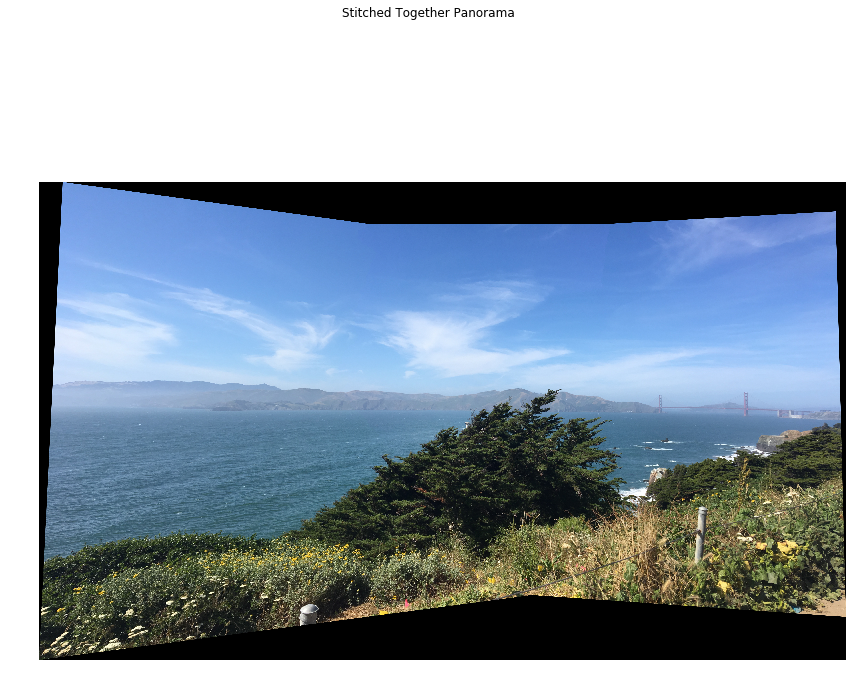

In [32]:
directory = '/Users/kategroschner/Downloads/bridge/*.JPG'
stitching_pipeline(directory)

## Extra: Image Stacking

Reprocess one of the datasets from http://www.rawastrodata.com/.  See http://www.rawastrodata.com/pages/typesofimages.html for a description of the different kind of images.